In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_original = pd.read_csv('weatherAUS.csv')
df_original.shape

(145460, 23)

In [3]:
df_original.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


The dataset is made up of daily meteorological records. It is easier to manipulate it transforming the date column into a datetime object and setting it as index

In [4]:
df_original.Date = pd.to_datetime(df_original.Date)
df_original.set_index('Date', inplace=True)

Aggregating similar columns reducing dimensionality

In [5]:
df = df_original.copy()
df['minmax_temp'] = df.MaxTemp - df.MinTemp
df['delta_wind'] = df.WindSpeed3pm - df.WindSpeed9am
df['delta_hum'] = df.Humidity3pm - df.Humidity9am
df['delta_pres'] = df.Pressure3pm - df.Pressure9am
df['delta_cloud'] = df.Cloud3pm - df.Cloud9am
df['delta_temp'] = df.Temp3pm - df.Temp9am

And dropping columns used to generate them

In [6]:
df.drop(['MinTemp', 'MaxTemp', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm'], axis=1,inplace=True)

Let's explore the Nan values

In [7]:
df.isna().mean().sort_values(ascending=False)[:6]

Sunshine       0.480098
delta_cloud    0.436560
Evaporation    0.431665
delta_pres     0.105108
WindDir9am     0.072639
WindGustDir    0.070989
dtype: float64

Some columns have 40% or more missing values. Might have to drop them entirely

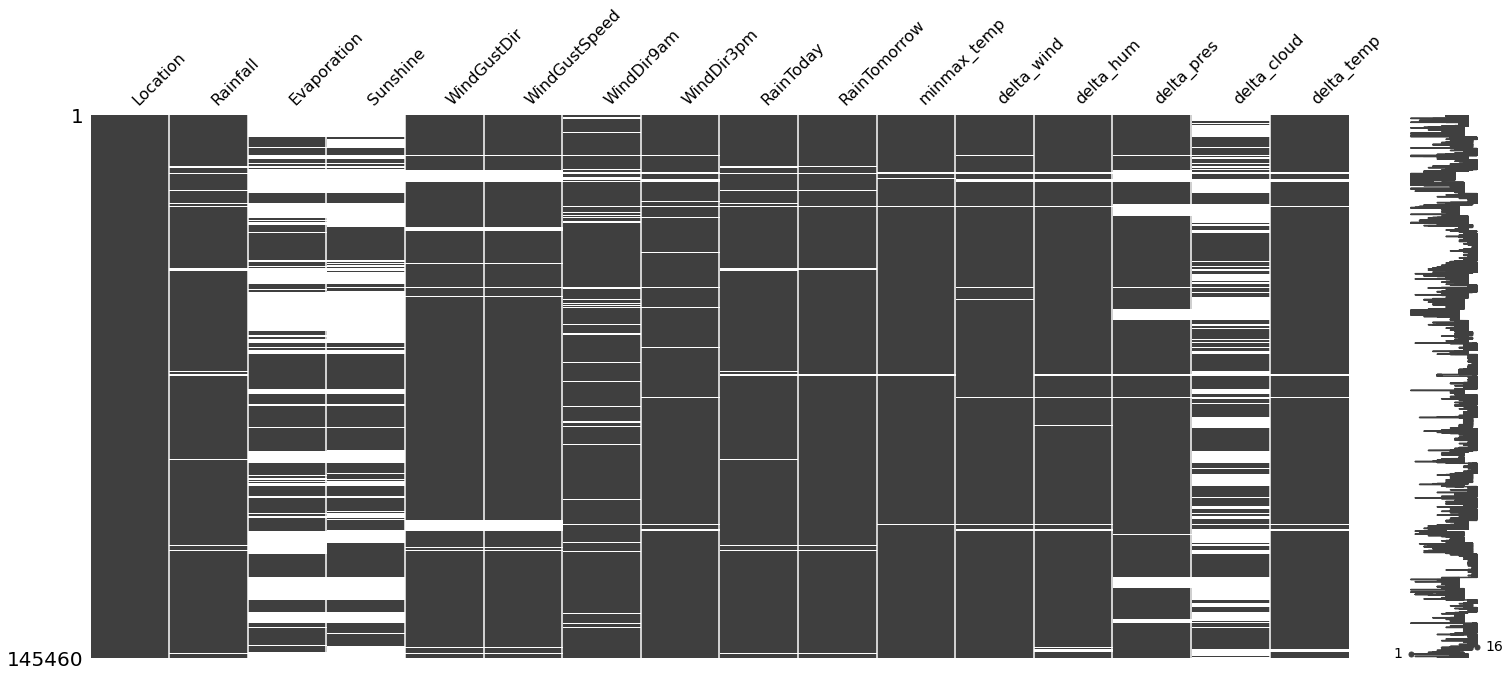

In [8]:
import missingno as msno
msno.matrix(df);

Since WindGustDir and WindGustSpeed are missing not at random, I am going to drop them whether they are both missing

In [9]:
df.dropna(subset=['WindGustDir','WindGustSpeed'],how='all',inplace=True)

In [10]:
num_cols = df.select_dtypes('float64').columns
cat_col = df.select_dtypes('object').columns

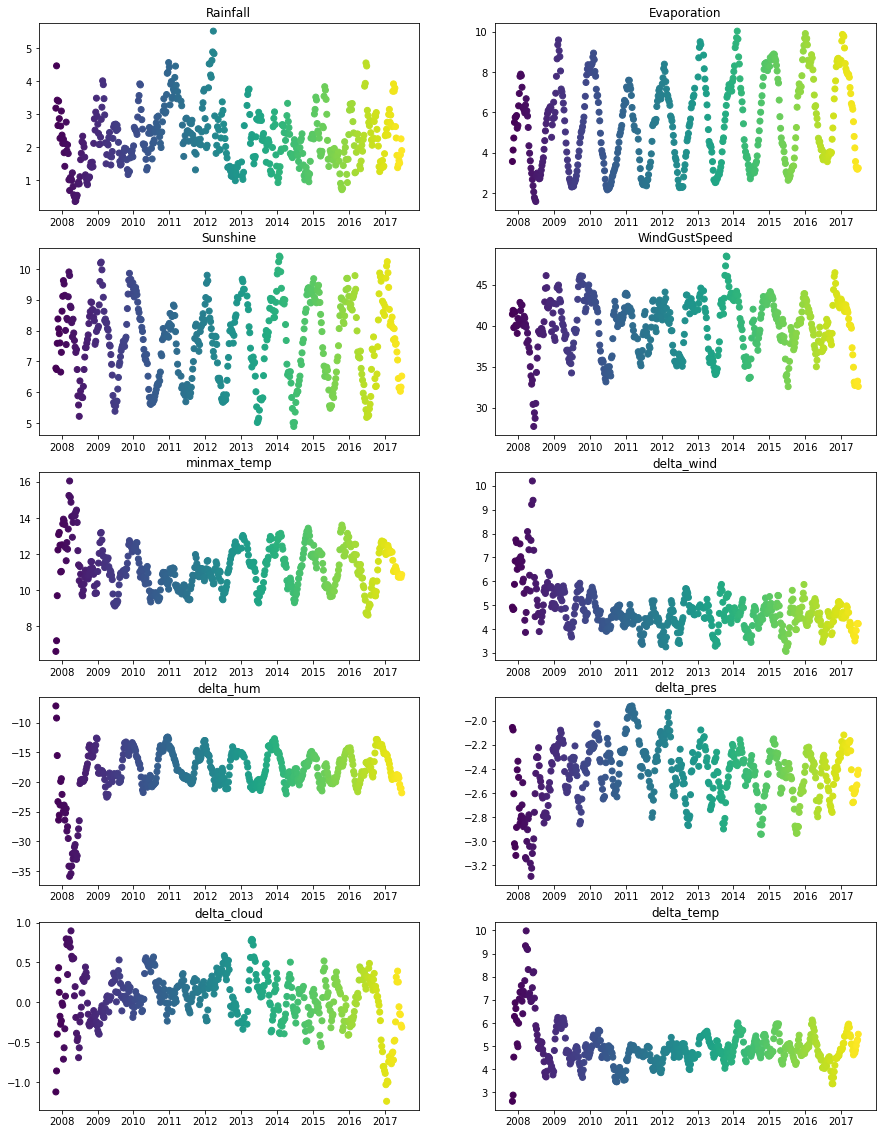

In [11]:
fig, axs = plt.subplots(5,2)
fig.set_size_inches(15, 20)

for col, ax in zip(num_cols, axs.flatten()):
    a=df[col].interpolate('time').rolling(30).mean()       #interpolating based on time and calculating an avarage for 30 days
    ax.scatter(y=a.resample('W').mean(),x=a.resample('W').mean().index, c=a.resample('W').mean().index, cmap='viridis')
    ax.set_title(col)
plt.show()

Looks like I can leverage the time series in order to fill missing values. Let's try out some interpolation

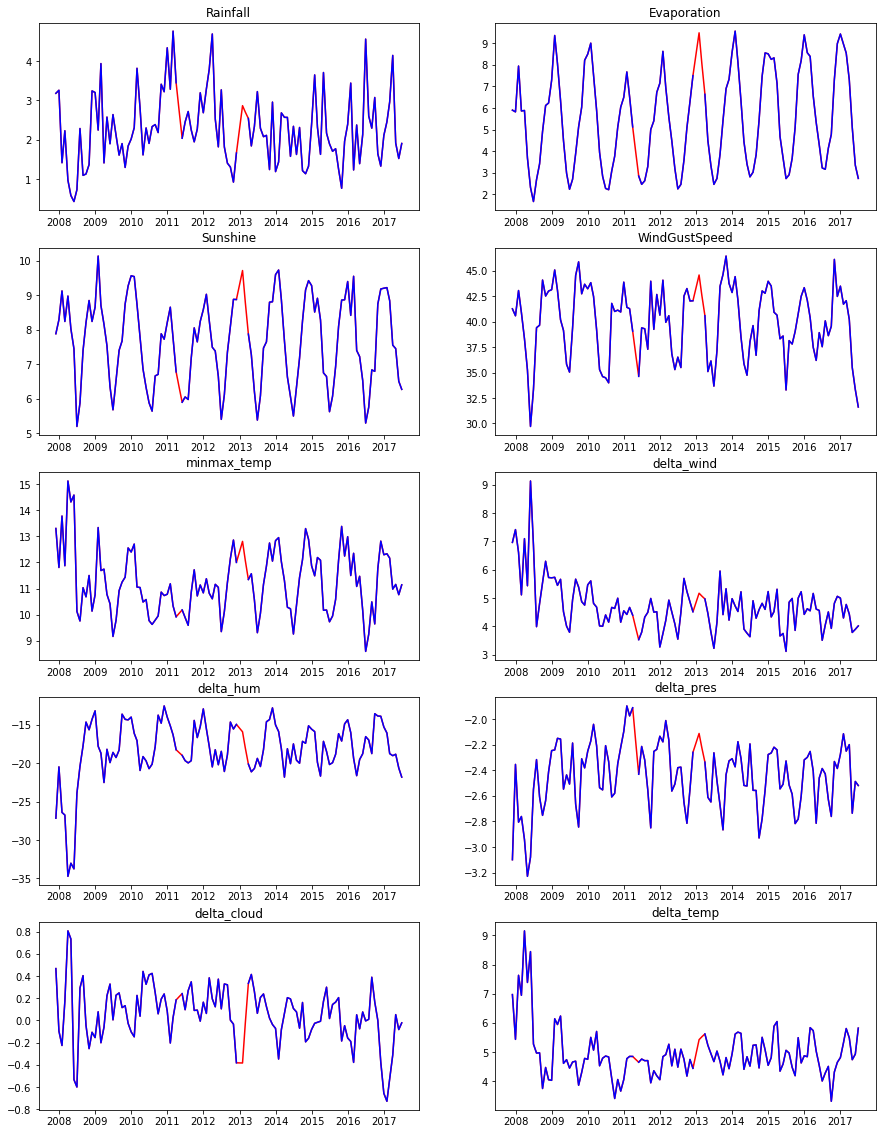

In [12]:
fig, axs = plt.subplots(5,2)
fig.set_size_inches(15,20)

for col, ax in zip(num_cols,axs.flatten()):
    ax.plot(df[col].resample('M').mean().interpolate('linear'),c='red')
    ax.plot(df[col].resample('M').mean(),c='blue')
    ax.set_title(col)
plt.show()

Let's see wether we can spot some correlation among the resampled numerical features

In [13]:
df_resampled = df.copy()
df_resampled = df.resample('M').mean()

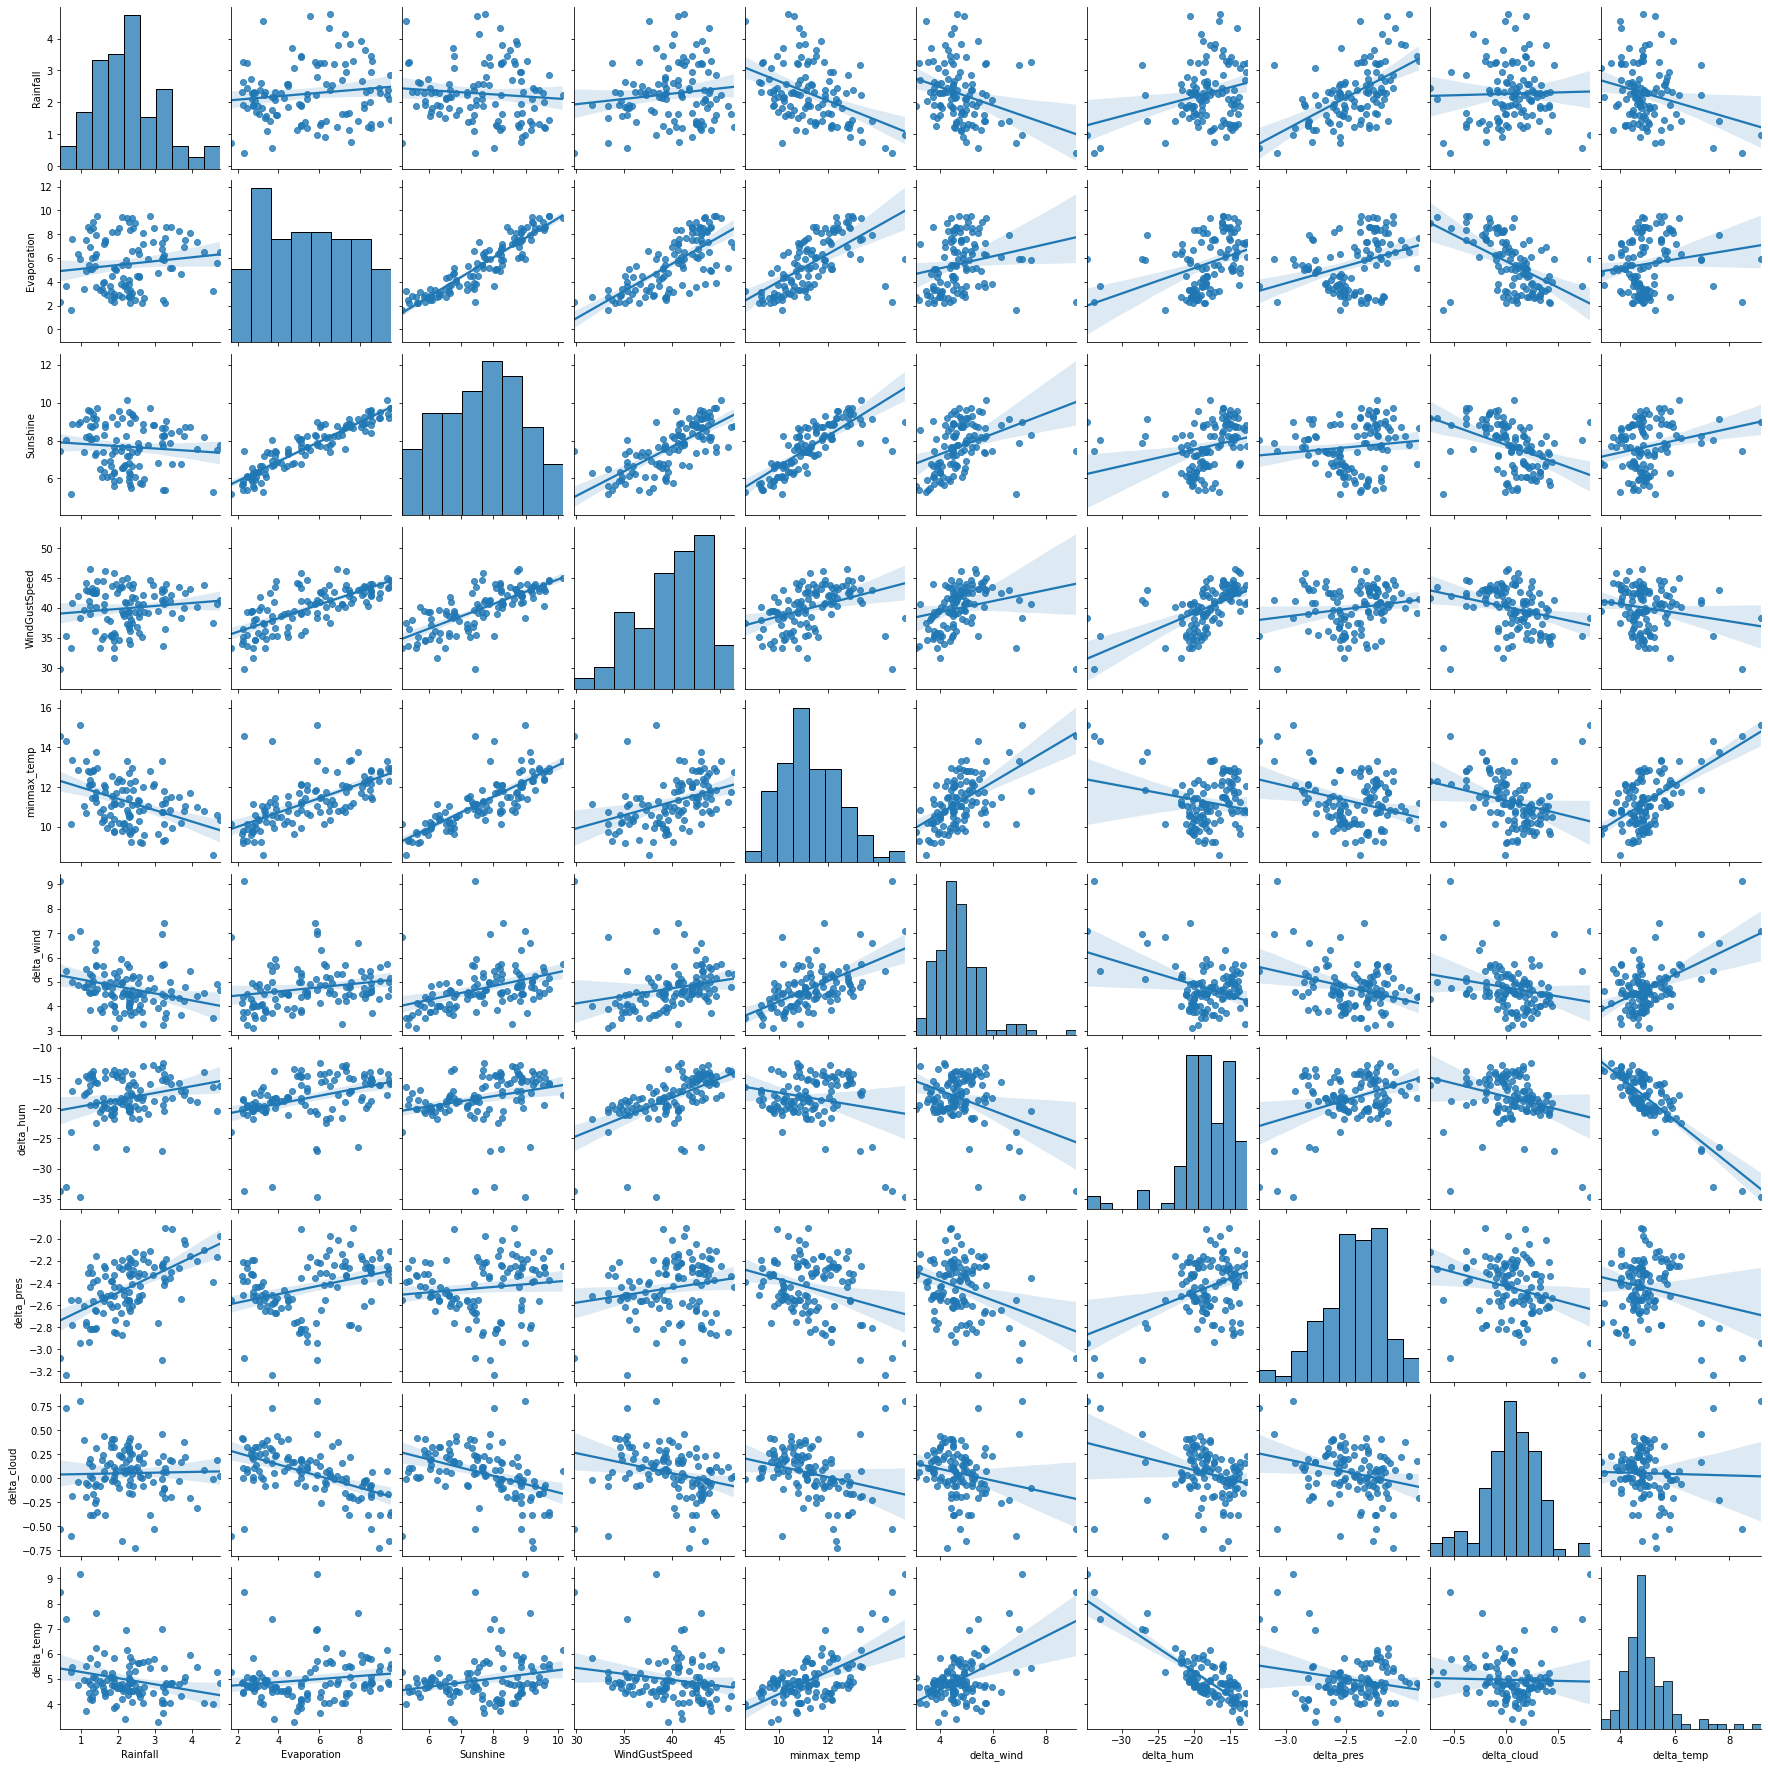

In [45]:
sns.pairplot(df_resampled,kind='reg');

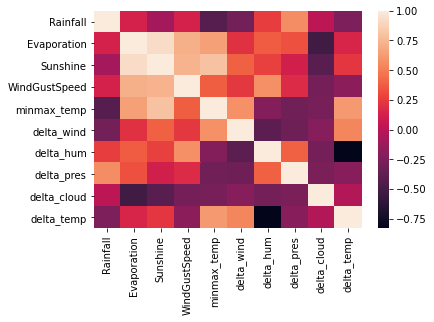

In [47]:
sns.heatmap(df_resampled.corr());

Dropping collinear columns

In [18]:
df.drop(['delta_hum','delta_cloud','Sunshine'],axis=1,inplace=True)

In [19]:
num_cols = df.select_dtypes('float64').columns
df[num_cols] = df[num_cols].interpolate('time').rolling(30).mean() #interpolating based on time and calculating an avarage for 30 days

Let's drop missing values in the target column

In [20]:
df.dropna(subset=['RainTomorrow'],how='any',inplace=True)

In [21]:
df.isnull().mean()*100

Location         0.000000
Rainfall         0.021817
Evaporation      4.470257
WindGustDir      0.045139
WindGustSpeed    0.021817
WindDir9am       5.696531
WindDir3pm       0.749306
RainToday        0.933623
RainTomorrow     0.000000
minmax_temp      0.021817
delta_wind       0.021817
delta_pres       0.021817
delta_temp       0.021817
dtype: float64

Interpolation reduced missing values drastically, although it did not reset them all

In [22]:
df.RainToday.value_counts(dropna=False)

No     102583
Yes     29099
NaN      1241
Name: RainToday, dtype: int64

Let's impute the mode to RainToday column missing values since relatively few data are missing and since 'No' values are ~3.5 times more common

In [23]:
df.RainToday.fillna(df.RainToday.mode()[0],inplace=True)

And drop the other missing values

In [24]:
df_cleaned = df.dropna()

In [25]:
print('Percentage of dropped data: {:.2f}'.format(100-(df_cleaned.shape[0]/df_original.shape[0]*100)))

Percentage of dropped data: 17.71


Standardizing using MinMaxScaler, encoding binary columns and creating dummies for categorical columns

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaled_df = df_cleaned.copy()
scaler = MinMaxScaler()
scaled_df[num_cols] = scaler.fit_transform(scaled_df[num_cols])

In [28]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
scaled_df[['RainToday','RainTomorrow']] = scaled_df[['RainToday','RainTomorrow']].apply(le.fit_transform).astype('int64')

In [29]:
scaled_df = pd.get_dummies(scaled_df)

In [30]:
scaled_df.RainTomorrow.value_counts(normalize=True)

0    0.775491
1    0.224509
Name: RainTomorrow, dtype: float64

Unfortunately the dataset is too massive to perform more complex algorithms or hyperparameter tuning, so I am using all the rows in which column RainTomorrow value is 1 and randomly selecting an equal amount of rows where it is 0 (without replacement). 

In [31]:
df_subset_neg = scaled_df[scaled_df.RainTomorrow==0].sample(n=scaled_df[scaled_df.RainTomorrow==1].shape[0], replace=False, random_state=46)
df_subset_pos = scaled_df[scaled_df.RainTomorrow==1]

df_reduced = pd.concat([df_subset_neg, df_subset_pos], axis = 0)
df_reduced.shape

(53748, 102)

In [33]:
print('Total dataset reduction: {:.2f} %'.format(100-(scaled_df[scaled_df.RainTomorrow==1].shape[0]*2/scaled_df.shape[0]*100)))

Total dataset reduction: 55.10 %


In [36]:
from sklearn.model_selection import train_test_split

X_red = df_reduced.drop(['RainTomorrow','Evaporation'], axis=1).values
y_red = df_reduced.RainTomorrow.values

X_tr_red , X_ts_red, y_tr_red, y_ts_red = train_test_split(X_red, y_red, test_size=0.2, shuffle=True, random_state=56)

My goal is evaluating which model would perform better, given a dictionary of different algorithms

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import VotingClassifier
import xgboost as xgb
from sklearn.model_selection import cross_val_score


models = {'LogR': LogisticRegression(),
          'DT': DecisionTreeClassifier(),
          'BaggingC' : BaggingClassifier(n_estimators = 20),
          'RF': RandomForestClassifier(),
          'AdaB': AdaBoostClassifier(),
          'XGBC': xgb.XGBClassifier(),
          'VC': VotingClassifier([('RF',RandomForestClassifier()),('XGBC',xgb.XGBClassifier())], voting='soft')} 

In [ ]:
def cv_mean_score(models,X_train,y_train,scoring):  #loops through collected models and outputs a dict with model and relative mean score
    model_performance = {}
    for name, model in models.items():
        scores = cross_val_score(model, X = X_train, y = y_train, cv = 10, scoring = scoring)
        model_performance[name] = np.mean(scores)
    return model_performance

auc_scores = cv_mean_score(models, X_tr_red, y_tr_red, 'roc_auc')

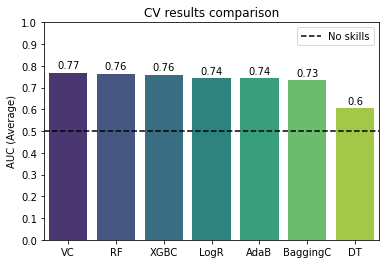

In [39]:
def choosing_best(dict_):  #takes a dict and outputs a barplot showing the mean scoring of all models
    df = pd.DataFrame(dict_.values(), index=dict_.keys(), columns = ['score']).sort_values('score',ascending=False)
    ax = sns.barplot(data = df, y='score', x=df.index, palette='viridis')
    ax.set(title='CV results comparison', ylabel = 'AUC (Average)', yticks = np.arange(0,1.1,0.1))
    ax.axhline(0.5, color = 'black', ls='--', label='No skills')
    ax.legend()
    
    for i, k in zip(round(df.score,2), ax.patches):
        ax.text(x = k.get_x() + k.get_width()/2, y = k.get_height()+0.02, s=i, ha='center')
    plt.show()

choosing_best(auc_scores)

VotingClassifier using the best two models shows ~ 1% improvement

In [ ]:
def getting_preds(X_train, y_train, X_test):   #returns preds and probs of all models
    preds = {}
    probs = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds[name] = model.predict(X_test)
        probs[name] = model.predict_proba(X_test)[:,1]
    return preds, probs

preds, probs = getting_preds(X_tr_red, y_tr_red, X_ts_red)

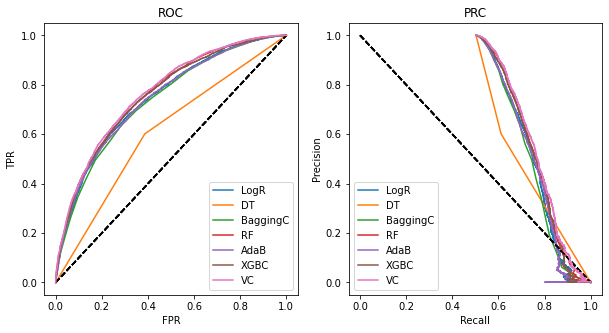

In [41]:
from sklearn.metrics import roc_curve, precision_recall_curve

def roc_prc(probs,y_test):   #outputs roc and prc curves graphs
    roc_params = {}
    prc_params = {}
    for name, prob in probs.items():
        roc_params[name] = roc_curve(y_test, prob)
        prc_params[name] = precision_recall_curve(y_test, prob)
            
    fig, ax = plt.subplots(1,2)
    fig.set_size_inches(10,5)
    
    for name, values in roc_params.items():
        ax[0].plot([0,1], 'k--')
        ax[0].plot(values[0], values[1], label = name)
        ax[0].set(title='ROC', xlabel = 'FPR', ylabel = 'TPR')
        ax[0].legend()
    
    for name, values in prc_params.items():
        ax[1].plot([1,0], 'k--')
        ax[1].plot(values[0],values[1], label = name)
        ax[1].set(title='PRC', xlabel= 'Recall', ylabel = 'Precision')
        ax[1].legend()
    
    plt.show()
        
        
roc_prc(probs,y_ts_red)           
